# SciFM Summer School - Introduction to Tokenization
The notebook demonstrates training a range of tokenizers using [HuggingFace's tokenizers](https://github.com/huggingface/tokenizers) on the [wikitext](https://github.com/huggingface/tokenizers) dataset. Later, you'll see a few tokenization demonstrations geared toward scientific data (Genomics and Molecules)

In [1]:
# Install Dependencies and Datasets
!pip install tokenizers datasets transformers selfies

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4

In [2]:
from datasets import load_dataset

ds = load_dataset("Salesforce/wikitext", "wikitext-2-raw-v1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

# Breaking down Tokenization
Originally, tokenization was the procress of breaking text into words or maybe grammatical units (i.e. `don't` → [`do`, `n't`]), but since the rise of subword tokens it's gotten a bit more complex (See _Between words and Charaters_, linked below). Today, tokenization consistes of the following steps:

1. Normalization: Clean up the text by converting it to an "equivalent" but easier to model form
2. Pre-tokenization: The old tokens are now "pretokens", this step splits a sentence into a sequence of words. Seems simple, but there are [**25** whitespace character](https://en.wikipedia.org/wiki/Whitespace_character) in Unicode.
3. Modeling: The new tokenizer! Converts a sequence of words into a sequence of token ids: [`hello`, `world`] →
4. Post-Processing: Some tasks need additional "special" tokens to deliminate parts of the sequence.

We're going to use [HuggingFace's tokenizers](https://github.com/huggingface/tokenizers) library for today's tutorial, as it's used by MIST and GenSLM. Other frameworks exist and HF doesn't cover _every_ tokenizer, but it's fast (🦀) and has Python bindings.

In [3]:
from tokenizers import Tokenizer

We're going to walk this bit of text through tokenization, feel free to change it to something fun

Some things to try out:

- Emojis" 🤖🧪🧬
- Latex: ∫sin(x)dx
- Something else from your scientific domain?

In [4]:
sample_text = """
In circuits bright, where minds align,
Foundation models, thoughts refine.
Through data's maze and logic's gleam,
They unveil truths from unseen dream.

With silicon heart and binary art,
They decode nature, play their part.
In algorithms crisp and true,
They bring us closer to what's new.

Oh, scientific wonders spun,
In bits and bytes, the quest is won.
From data vast, they draw their power,
To shape the future, hour by hour.
"""

First, we'll make the input test "easier" to model by modifying it:
- Lowercase everything
- Remove leading/trailing whitespace
- Replace Unicode charathers with something "equivalent". We don't do this below, but [HF supports several methods](https://huggingface.co/docs/tokenizers/api/normalizers)


In [5]:
from tokenizers import normalizers
norm = normalizers.Sequence([
    normalizers.Strip(),
    normalizers.Lowercase(),
])
sample_normed = norm.normalize_str(sample_text)
sample_normed

"in circuits bright, where minds align,\nfoundation models, thoughts refine.\nthrough data's maze and logic's gleam,\nthey unveil truths from unseen dream.\n\nwith silicon heart and binary art,\nthey decode nature, play their part.\nin algorithms crisp and true,\nthey bring us closer to what's new.\n\noh, scientific wonders spun,\nin bits and bytes, the quest is won.\nfrom data vast, they draw their power,\nto shape the future, hour by hour."

Next we need to identify the "words" that make up the text and split them into "pre-tokens"
- Are numbers words? `123` -> [`13243`] or [`1`, `3`, `2`]
- Are space important?  [`京都 清水寺の写真`](https://translate.google.com/?sl=auto&tl=en&text=%E4%BA%AC%E9%83%BD%20%E6%B8%85%E6%B0%B4%E5%AF%BA%E3%81%AE%E5%86%99%E7%9C%9F&op=translate) -> [`_京都_`, `_清水寺`, `の写真`]
- What even is a word? `C(Cc1cc(c(OC)c(OC)c1)OC)N` -> [`C`, `(`, `C`, ...]


In [27]:
from tokenizers import pre_tokenizers
pretok = pre_tokenizers.Sequence([
    pre_tokenizers.Punctuation(),
    pre_tokenizers.Whitespace(),
])
sample_pretok = pretok.pre_tokenize_str(sample_normed)
sample_pretok[:20]

[('in', (0, 2)),
 ('circuits', (3, 11)),
 ('bright', (12, 18)),
 (',', (18, 19)),
 ('where', (20, 25)),
 ('minds', (26, 31)),
 ('align', (32, 37)),
 (',', (37, 38)),
 ('foundation', (39, 49)),
 ('models', (50, 56)),
 (',', (56, 57)),
 ('thoughts', (58, 66)),
 ('refine', (67, 73)),
 ('.', (73, 74)),
 ('through', (75, 82)),
 ('data', (83, 87)),
 ("'", (87, 88)),
 ('s', (88, 89)),
 ('maze', (90, 94)),
 ('and', (95, 98))]

Now that we have a sequence of "words", we need to a model to convert it into a sequence of tokens. To start we're going to train a WordLevel model.

1. Collect all the unique words in the corpus
2. Assign a token to each word
3. At inference time, the unknown token is used for any unknown words

In [7]:

from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer

tok_wl = Tokenizer(WordLevel(unk_token="[UNK]"))
tok_wl.normalizer = norm
tok_wl.pre_tokenizer = pretok
trainer = WordLevelTrainer(special_tokens=["[UNK]"])  # Don't forget to add the Unknown token!
tok_wl.train_from_iterator(ds["train"]["text"], trainer)

In [8]:
from tokenizers.tools import EncodingVisualizer

""" Helper function for comparing different tokenizers. There's not much going
on here, just encoding the text and printing out the results. The (limited)
complexity comes from handling multiple tokenizer types (transformers and tokenizers)
plus single ("hello") and paired ("Whose got it better than us?", "NOBODY!") text
 """
def demo_tokenizer(tok, text=sample_text):
    if not isinstance(text, tuple):
        text = (text, )

    if not isinstance(tok, Tokenizer):
      tok = tok.backend_tokenizer

    out = tok.encode(*text)
    ids = out.ids
    tokens = out.tokens
    token_type = None
    sz = tok.get_vocab_size()

    print(f"Input: `{text}`")
    print(f"Tokens: {tokens}")
    print(f"Tokens IDs: {ids}")
    token_type and print(f"Tokens Type: {token_type}")
    print(f"Vocab Size: {sz}")

    if len(text) == 1:
      vis = EncodingVisualizer(tok)
      vis(*text)


In [9]:
demo_tokenizer(tok_wl)

Input: `("\nIn circuits bright, where minds align,\nFoundation models, thoughts refine.\nThrough data's maze and logic's gleam,\nThey unveil truths from unseen dream.\n\nWith silicon heart and binary art,\nThey decode nature, play their part.\nIn algorithms crisp and true,\nThey bring us closer to what's new.\n\nOh, scientific wonders spun,\nIn bits and bytes, the quest is won.\nFrom data vast, they draw their power,\nTo shape the future, hour by hour.\n",)`
Tokens: ['in', 'circuits', 'bright', ',', 'where', 'minds', 'align', ',', 'foundation', 'models', ',', 'thoughts', 'refine', '.', 'through', 'data', "'", 's', 'maze', 'and', 'logic', "'", 's', '[UNK]', ',', 'they', '[UNK]', 'truths', 'from', 'unseen', 'dream', '.', 'with', 'silicon', 'heart', 'and', 'binary', 'art', ',', 'they', '[UNK]', 'nature', ',', 'play', 'their', 'part', '.', 'in', 'algorithms', '[UNK]', 'and', 'true', ',', 'they', 'bring', 'us', 'closer', 'to', 'what', "'", 's', 'new', '.', 'oh', ',', 'scientific', 'wonders'

# Post-Processing
Finally, we can post process our tokens to add "special" tokens to deliminate regions of our input. For example, BERT uses a `[CLS]` token to indicate the start of a sequence and `[SEP]` to seperate a question from it's answer.





In [10]:
# Some models need extra tokens to deliminate different parts of the input
from tokenizers import processors
from copy import deepcopy

tok_wl_post = deepcopy(tok_wl)
tok_wl_post.add_special_tokens(["[SEP]", "[CLS]"])
tok_wl_post.post_processor = processors.BertProcessing(
    sep=("[SEP]", tok_wl_post.token_to_id("[SEP]")),
    cls=("[CLS]", tok_wl_post.token_to_id("[CLS]")),
)
print(f"Tokenize a single sentence: {tok_wl_post.encode(sample_text).tokens}")
print(f"A Pair of sentences: {tok_wl_post.encode('', sample_text).tokens}")

Tokenize a single sentence: ['[CLS]', 'in', 'circuits', 'bright', ',', 'where', 'minds', 'align', ',', 'foundation', 'models', ',', 'thoughts', 'refine', '.', 'through', 'data', "'", 's', 'maze', 'and', 'logic', "'", 's', '[UNK]', ',', 'they', '[UNK]', 'truths', 'from', 'unseen', 'dream', '.', 'with', 'silicon', 'heart', 'and', 'binary', 'art', ',', 'they', '[UNK]', 'nature', ',', 'play', 'their', 'part', '.', 'in', 'algorithms', '[UNK]', 'and', 'true', ',', 'they', 'bring', 'us', 'closer', 'to', 'what', "'", 's', 'new', '.', 'oh', ',', 'scientific', 'wonders', 'spun', ',', 'in', 'bits', 'and', '[UNK]', ',', 'the', 'quest', 'is', 'won', '.', 'from', 'data', 'vast', ',', 'they', 'draw', 'their', 'power', ',', 'to', 'shape', 'the', 'future', ',', 'hour', 'by', 'hour', '.', '[SEP]']
A Pair of sentences: ['[CLS]', '[SEP]', 'in', 'circuits', 'bright', ',', 'where', 'minds', 'align', ',', 'foundation', 'models', ',', 'thoughts', 'refine', '.', 'through', 'data', "'", 's', 'maze', 'and', 'log

# Splitting Words into Subwords

## Byte-Pair Encoding
BPE has it's roots as a data compression algorithum and is used in a few well-known models (i.e. GPT-2). We're going to do a deeper dive into this in a bit, but at a high-level:

1. Split the corpus into words
2. Init the vocab with the alphabet (Roughly)
3. Count the frequency of co-occuring bytes
3. Merge the most freqent pairs into a meta-token
4. Repeat until the vocab hits the target size or there are no more merges to make

In [11]:
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer

tok_bpe = Tokenizer(BPE(unk_token="[UNK]"))
tok_bpe.normalizer = norm
tok_bpe.pre_tokenizer = pretok
trainer = BpeTrainer(
    vocab_size=tok_wl.get_vocab_size(), # Not a great choice, but helpful for comparison
    special_tokens=["[UNK]"],
    show_progress=True
)
tok_bpe.train_from_iterator(
    ds["train"]["text"],
    trainer,
    length=len(ds["train"])
)

In [12]:
demo_tokenizer(tok_bpe)

Input: `("\nIn circuits bright, where minds align,\nFoundation models, thoughts refine.\nThrough data's maze and logic's gleam,\nThey unveil truths from unseen dream.\n\nWith silicon heart and binary art,\nThey decode nature, play their part.\nIn algorithms crisp and true,\nThey bring us closer to what's new.\n\nOh, scientific wonders spun,\nIn bits and bytes, the quest is won.\nFrom data vast, they draw their power,\nTo shape the future, hour by hour.\n",)`
Tokens: ['in', 'circuits', 'bright', ',', 'where', 'minds', 'align', ',', 'foundation', 'models', ',', 'thoughts', 'refine', '.', 'through', 'data', "'", 's', 'maze', 'and', 'logic', "'", 's', 'gle', 'am', ',', 'they', 'unve', 'il', 'truths', 'from', 'unseen', 'dream', '.', 'with', 'silicon', 'heart', 'and', 'binary', 'art', ',', 'they', 'de', 'code', 'nature', ',', 'play', 'their', 'part', '.', 'in', 'algorithms', 'cris', 'p', 'and', 'true', ',', 'they', 'bring', 'us', 'closer', 'to', 'what', "'", 's', 'new', '.', 'oh', ',', 'scie

## WordPiece
As Google never open-sourced WordPiece the exact algorithm is unknown. HuggingFace's WordPiece trainer is actually just a [wrapper around their BPE trainer](https://github.com/huggingface/tokenizers/blob/fdd26ba9a3f0c133427aab0423888cbde91362d7/tokenizers/src/models/wordpiece/trainer.rs#L165C4-L177C6) with an added flag to add a subword prefix.

There are few other differences from BPE, _as implimented by HuggingFace_, including:
- Instead of tokenizing and then applying merges, WordPiece uses the largest matching token
- If WordPiece can't tokenize part of a word it marks _the whole word_ as unknown

In [13]:
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer

tok_wp = Tokenizer(WordPiece(unk_token="[UNK]"))
tok_wp.normalizer = norm
tok_wp.pre_tokenizer = pretok
trainer = WordPieceTrainer(
    vocab_size=tok_wl.get_vocab_size(), # Not a great choice, but helpful for comparison
    special_tokens=["[UNK]"],
    show_progress=True,
)
tok_wp.train_from_iterator(
    ds["train"]["text"],
    trainer,
    length=len(ds["train"])
)

In [14]:
demo_tokenizer(tok_wp)

Input: `("\nIn circuits bright, where minds align,\nFoundation models, thoughts refine.\nThrough data's maze and logic's gleam,\nThey unveil truths from unseen dream.\n\nWith silicon heart and binary art,\nThey decode nature, play their part.\nIn algorithms crisp and true,\nThey bring us closer to what's new.\n\nOh, scientific wonders spun,\nIn bits and bytes, the quest is won.\nFrom data vast, they draw their power,\nTo shape the future, hour by hour.\n",)`
Tokens: ['in', 'circuits', 'bright', ',', 'where', 'minds', 'ali', '##gn', ',', 'foundation', 'models', ',', 'thoughts', 'refine', '.', 'through', 'data', "'", 's', 'maze', 'and', 'logic', "'", 's', 'gle', '##am', ',', 'they', 'unve', '##il', 'truth', '##s', 'from', 'unseen', 'dream', '.', 'with', 'silicon', 'heart', 'and', 'binary', 'art', ',', 'they', 'dec', '##ode', 'nature', ',', 'play', 'their', 'part', '.', 'in', 'algorithms', 'cris', '##p', 'and', 'true', ',', 'they', 'bring', 'us', 'closer', 'to', 'what', "'", 's', 'new', '

## Unigram
Unlike BPE/WordPiece which build their vocabulary from an intial (small) alphabet, Unigram starts with a large vocabulary and then iteratively removes tokens that don't contribute much.

1. Compute the most probable tokenization of the corpus
2. Repeat but using a vocabulary that holds out a token, record the log-likelihood of the resulting model
3. Removed the bottom X% of tokens (the ones with the smallest change in the log-likelihood when removed)
4. Repeat till the vocab reaches the target size

Conceptually at infrence time (HF doesn't impliment this), multiple tokenization can then be computed and then sampled from based on their proability.

In [15]:
from tokenizers.models import Unigram
from tokenizers.trainers import UnigramTrainer

tok_uni = Tokenizer(Unigram())
tok_uni.normalizer = norm
tok_uni.pre_tokenizer = pretok
trainer = UnigramTrainer(
    vocab_size=tok_wl.get_vocab_size() // 2, # Not a great choice, but helpful for comparison
    unk_token="[UNK]",
    shrinking_factor=0.1,
    show_progress=True,
)
tok_uni.train_from_iterator(
    ds["train"]["text"],
    trainer,
    length=len(ds["train"])
)

In [16]:
demo_tokenizer(tok_uni)

Input: `("\nIn circuits bright, where minds align,\nFoundation models, thoughts refine.\nThrough data's maze and logic's gleam,\nThey unveil truths from unseen dream.\n\nWith silicon heart and binary art,\nThey decode nature, play their part.\nIn algorithms crisp and true,\nThey bring us closer to what's new.\n\nOh, scientific wonders spun,\nIn bits and bytes, the quest is won.\nFrom data vast, they draw their power,\nTo shape the future, hour by hour.\n",)`
Tokens: ['in', 'circuit', 's', 'bright', ',', 'where', 'mind', 's', 'align', ',', 'foundation', 'model', 's', ',', 'thought', 's', 'refine', '.', 'through', 'data', "'", 's', 'maze', 'and', 'logic', "'", 's', 'g', 'le', 'a', 'm', ',', 'they', 'unveil', 'truth', 's', 'from', 'unseen', 'dream', '.', 'with', 'silicon', 'heart', 'and', 'binar', 'y', 'art', ',', 'they', 'd', 'e', 'code', 'nature', ',', 'play', 'their', 'part', '.', 'in', 'algorithm', 's', 'cris', 'p', 'and', 'true', ',', 'they', 'bring', 'us', 'closer', 'to', 'what', "'

# Pre-Trained Tokenizers
Don't want to train your own tokenizer? Try out a pre-trained one

In [17]:
from transformers import AutoTokenizer
import selfies

In [18]:
tok_gpt = AutoTokenizer.from_pretrained("openai-community/gpt2")
demo_tokenizer(tok_gpt)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Input: `("\nIn circuits bright, where minds align,\nFoundation models, thoughts refine.\nThrough data's maze and logic's gleam,\nThey unveil truths from unseen dream.\n\nWith silicon heart and binary art,\nThey decode nature, play their part.\nIn algorithms crisp and true,\nThey bring us closer to what's new.\n\nOh, scientific wonders spun,\nIn bits and bytes, the quest is won.\nFrom data vast, they draw their power,\nTo shape the future, hour by hour.\n",)`
Tokens: ['Ċ', 'In', 'Ġcircuits', 'Ġbright', ',', 'Ġwhere', 'Ġminds', 'Ġalign', ',', 'Ċ', 'Found', 'ation', 'Ġmodels', ',', 'Ġthoughts', 'Ġrefine', '.', 'Ċ', 'Through', 'Ġdata', "'s", 'Ġmaze', 'Ġand', 'Ġlogic', "'s", 'Ġgle', 'am', ',', 'Ċ', 'They', 'Ġunveil', 'Ġtruths', 'Ġfrom', 'Ġunseen', 'Ġdream', '.', 'Ċ', 'Ċ', 'With', 'Ġsilicon', 'Ġheart', 'Ġand', 'Ġbinary', 'Ġart', ',', 'Ċ', 'They', 'Ġdecode', 'Ġnature', ',', 'Ġplay', 'Ġtheir', 'Ġpart', '.', 'Ċ', 'In', 'Ġalgorithms', 'Ġcrisp', 'Ġand', 'Ġtrue', ',', 'Ċ', 'They', 'Ġbring', 'Ġus',

In [19]:
tok_galactica = AutoTokenizer.from_pretrained("facebook/galactica-125m")
demo_tokenizer(tok_galactica)

tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.00 [00:00<?, ?B/s]

Input: `("\nIn circuits bright, where minds align,\nFoundation models, thoughts refine.\nThrough data's maze and logic's gleam,\nThey unveil truths from unseen dream.\n\nWith silicon heart and binary art,\nThey decode nature, play their part.\nIn algorithms crisp and true,\nThey bring us closer to what's new.\n\nOh, scientific wonders spun,\nIn bits and bytes, the quest is won.\nFrom data vast, they draw their power,\nTo shape the future, hour by hour.\n",)`
Tokens: ['Ċ', 'In', 'Ġcircuits', 'Ġbright', ',', 'Ġwhere', 'Ġmind', 's', 'Ġalign', ',', 'Ċ', 'Found', 'ation', 'Ġmodels', ',', 'Ġthoughts', 'Ġrefine', '.', 'Ċ', 'Through', 'Ġdata', "'", 's', 'Ġmaze', 'Ġand', 'Ġlogic', "'", 's', 'Ġg', 'le', 'am', ',', 'Ċ', 'They', 'Ġunve', 'il', 'Ġtruth', 's', 'Ġfrom', 'Ġunseen', 'Ġdream', '.', 'Ċ', 'Ċ', 'With', 'Ġsilicon', 'Ġheart', 'Ġand', 'Ġbinary', 'Ġart', ',', 'Ċ', 'They', 'Ġdecode', 'Ġnature', ',', 'Ġplay', 'Ġtheir', 'Ġpart', '.', 'Ċ', 'In', 'Ġalgorithms', 'Ġcrisp', 'Ġand', 'Ġtrue', ',', 'Ċ', 

In [20]:
# Some Tokenizers are designed for pairs of sentences (Think RAG)
tok_qa = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
demo_tokenizer(tok_qa, ("How can I learn more about Scientific Foundation Models?", "Attend SciFM Summer School!"))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Input: `('How can I learn more about Scientific Foundation Models?', 'Attend SciFM Summer School!')`
Tokens: ['[CLS]', 'how', 'can', 'i', 'learn', 'more', 'about', 'scientific', 'foundation', 'models', '?', '[SEP]', 'attend', 'sci', '##fm', 'summer', 'school', '!', '[SEP]']
Tokens IDs: [101, 2129, 2064, 1045, 4553, 2062, 2055, 4045, 3192, 4275, 1029, 102, 5463, 16596, 16715, 2621, 2082, 999, 102]
Vocab Size: 30522


In [21]:
# FYI: Do check the remote code before running it on your own system.
tok_molformer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)
demo_tokenizer(tok_molformer, "C1=CC2=C(C=C1O)C(=CN2)CCN")

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenization_molformer_fast.py:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

tokenization_molformer.py:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Input: `('C1=CC2=C(C=C1O)C(=CN2)CCN',)`
Tokens: ['<bos>', 'C', '1', '=', 'C', 'C', '2', '=', 'C', '(', 'C', '=', 'C', '1', 'O', ')', 'C', '(', '=', 'C', 'N', '2', ')', 'C', 'C', 'N', '<eos>']
Tokens IDs: [0, 4, 8, 12, 4, 4, 11, 12, 4, 6, 4, 12, 4, 8, 9, 7, 4, 6, 12, 4, 10, 11, 7, 4, 4, 10, 1]
Vocab Size: 2362


In [22]:
tok_selformer = AutoTokenizer.from_pretrained("HUBioDataLab/SELFormer")
demo_tokenizer(tok_selformer, selfies.encoder("C1=CC2=C(C=C1O)C(=CN2)CCN"))

tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/4.41k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.43k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Input: `('[C][=C][C][=C][Branch1][=Branch1][C][=C][Ring1][=Branch1][O][C][=Branch1][Branch1][=C][N][Ring1][Branch2][C][C][N]',)`
Tokens: ['<s>', 'C', '=', 'C', 'C', '=', 'C', 'Branch', '1', '=', 'Branch', '1', 'C', '=', 'C', 'Ring', '1', '=', 'Branch', '1', 'O', 'C', '=', 'Branch', '1', 'Branch', '1', '=', 'C', 'N', 'Ring', '1', 'Branch', '2', 'C', 'C', 'N', '</s>']
Tokens IDs: [1, 25, 21, 25, 25, 21, 25, 55, 12, 21, 55, 12, 25, 21, 25, 60, 12, 21, 55, 12, 33, 25, 21, 55, 12, 55, 12, 21, 25, 32, 60, 12, 55, 13, 25, 25, 32, 2]
Vocab Size: 428


# Comparing Tokenizers

In [23]:
trained = {
    "WordLevel": tok_wl,
    "BPE": tok_bpe,
    "WordPiece": tok_wp,
    "Unigram": tok_uni,
    "GPT-2": tok_gpt,
    "Galactica": tok_galactica,
    "BERT": tok_qa,
    # Using a tokenizer for molecules on articles from wikipedia doesn't really make sense.
    # But this is Summer School! So take chances, make mistakes, and get messy!
    # "MoLFormer": tok_molformer,
    # "SELFormer": tok_selformer,   # ditto
}

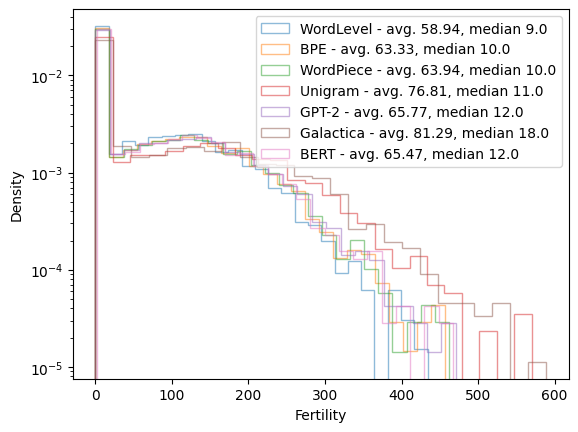

In [24]:
import matplotlib.pyplot as plt
from numpy import mean, median

def encode(tok, x):
  if isinstance(tok, Tokenizer):
    return tok.encode(x["text"]).ids
  else:
    return tok(x["text"])["input_ids"]

for name, tok in trained.items():
    fertility = [len(encode(tok, x)) for x in ds["validation"]]
    label = f"{name} - avg. {mean(fertility):.2f}, median {median(fertility):.1f}"
    plt.hist(fertility, bins="scott", alpha=0.5, label=label, density=True, log=True, histtype='step')

plt.xlabel('Fertility')
plt.ylabel('Density')
plt.legend()
plt.show()

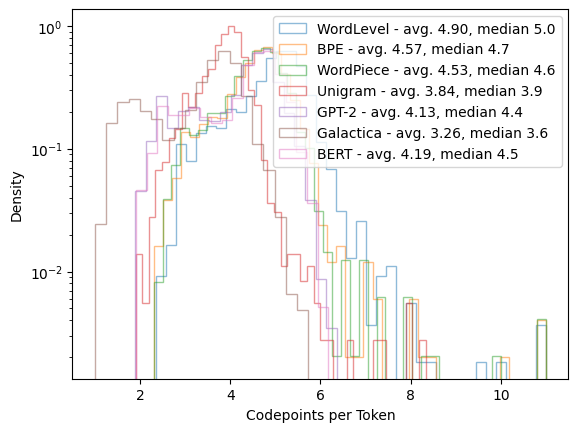

In [25]:
for name, tok in trained.items():
    fertility = [len(x["text"]) / len(encode(tok, x)) for x in ds["validation"] if len(x["text"]) > 0]
    label = f"{name} - avg. {mean(fertility):.2f}, median {median(fertility):.1f}"
    plt.hist(fertility, bins="scott", alpha=0.5, label=label, density=True, log=True, histtype='step')

plt.xlabel('Codepoints per Token')
plt.ylabel('Density')
plt.legend()
plt.show()

In [26]:
num_unknown = dict()
for name, tok in trained.items():
    if isinstance(tok, Tokenizer):
        unk_token_id = tok.get_vocab()["[UNK]"]
    else:
        unk_token_id = tok.unk_token_id or None

    num_unknown[name] = sum([ unk_token_id in encode(tok, x) for x in ds["validation"]]) / len(ds["validation"])

num_unknown

{'WordLevel': 0.45851063829787236,
 'BPE': 0.007978723404255319,
 'WordPiece': 0.007978723404255319,
 'Unigram': 0.007978723404255319,
 'GPT-2': 0.0,
 'Galactica': 0.0,
 'BERT': 0.006117021276595745}

# What's Next?
Check out these resources:

- [HuggingFace's Documentation](https://huggingface.co/docs/tokenizers/index)
- [HuggingFace's Tokenization NLP Course](https://huggingface.co/learn/nlp-course/chapter6/1)
- [Google's SentencePiece Library](https://github.com/google/sentencepiece)

Some papers:
- [Japanese and Korean voice search](https://doi.org/10.1109/ICASSP.2012.6289079): The WordPiece Paper
- [Subword Regularization: Improving Neural Network Translation Models with Multiple Subword Candidates](https://doi.org/10.18653/v1/P18-1007): The Unigram Paper
- [A new algorithm for data compression](https://www.semanticscholar.org/paper/A-new-algorithm-for-data-compression-Gage/1aa9c0045f1fe8c79cce03c7c14ef4b4643a21f8) - Created BPE as a compression algorithm
- [Neural Machine Translation of Rare Words with Subword Units](http://arxiv.org/abs/1508.07909) - Proposed using BPE for Neural Machine Translation
- [“Found in Translation”: predicting outcomes of complex organic chemistry reactions using neural sequence-to-sequence models](https://doi.org/10.1039/C8SC02339E): Proposed Regular Expression for Splitting Molecules (Thanks [Philippe Schwaller](https://scholar.google.com/citations?user=Tz0I4ywAAAAJ)!)
- [Between words and characters: A Brief History of Open-Vocabulary Modeling and Tokenization in NLP](http://arxiv.org/abs/2112.10508)
- [Exploring bert’s vocabulary](http://juditacs.github.io/2019/02/19/bert-tokenization-stats.html) a blog post by [Judit Ács](https://scholar.google.hu/citations?user=rIStlyMAAAAJ&hl=en) that introduced fertility as a metric. Later used by [Workshop et al. 2023](http://arxiv.org/abs/2211.05100), [Rust et al. 2021](https://doi.org/10.18653/v1/2021.acl-long.243), [Ali et al. 2024](http://arxiv.org/abs/2310.08754) and now you!